## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}

for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 10s 197us/step - loss: 2.4626 - accuracy: 0.0994 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 10s 197us/step - loss: 2.4626 - accuracy: 0.0985 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 10s 197us/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________

50000/50000 [==============================] - 10s 196us/step - loss: 2.8315 - accuracy: 0.6186 - val_loss: 3.0544 - val_accuracy: 0.5342
Epoch 46/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.7799 - accuracy: 0.6240 - val_loss: 3.0030 - val_accuracy: 0.5338
Epoch 47/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.7438 - accuracy: 0.6263 - val_loss: 2.9946 - val_accuracy: 0.5303
Epoch 48/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.7115 - accuracy: 0.6264 - val_loss: 3.2170 - val_accuracy: 0.4729
Epoch 49/50
50000/50000 [==============================] - 10s 195us/step - loss: 2.6757 - accuracy: 0.6280 - val_loss: 2.9901 - val_accuracy: 0.5134
Epoch 50/50
50000/50000 [==============================] - 10s 194us/step - loss: 2.6386 - accuracy: 0.6294 - val_loss: 2.8926 - val_accuracy: 0.5358
Experiment with Regulizer = 0.000000
Model: "model_1"
__________________________________________________________

50000/50000 [==============================] - 10s 194us/step - loss: 0.9678 - accuracy: 0.6596 - val_loss: 1.3955 - val_accuracy: 0.5199
Epoch 43/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.9546 - accuracy: 0.6646 - val_loss: 1.4103 - val_accuracy: 0.5194
Epoch 44/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.9420 - accuracy: 0.6705 - val_loss: 1.3815 - val_accuracy: 0.5308
Epoch 45/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.9278 - accuracy: 0.6746 - val_loss: 1.5634 - val_accuracy: 0.4943
Epoch 46/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.9208 - accuracy: 0.6776 - val_loss: 1.3818 - val_accuracy: 0.5297
Epoch 47/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.9075 - accuracy: 0.6816 - val_loss: 1.5530 - val_accuracy: 0.4937
Epoch 48/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.8994 - accuracy: 0.6841 - va

50000/50000 [==============================] - 10s 198us/step - loss: 1.0142 - accuracy: 0.6437 - val_loss: 1.3702 - val_accuracy: 0.5271
Epoch 40/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.9997 - accuracy: 0.6493 - val_loss: 1.3916 - val_accuracy: 0.5183
Epoch 41/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.9875 - accuracy: 0.6531 - val_loss: 1.3629 - val_accuracy: 0.5314
Epoch 42/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.9789 - accuracy: 0.6568 - val_loss: 1.3746 - val_accuracy: 0.5252
Epoch 43/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.9668 - accuracy: 0.6610 - val_loss: 1.4179 - val_accuracy: 0.5146
Epoch 44/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.9562 - accuracy: 0.6639 - val_loss: 1.4345 - val_accuracy: 0.5086
Epoch 45/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.9427 - accuracy: 0.6691 - val

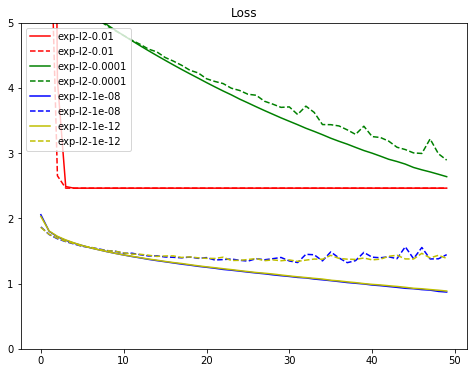

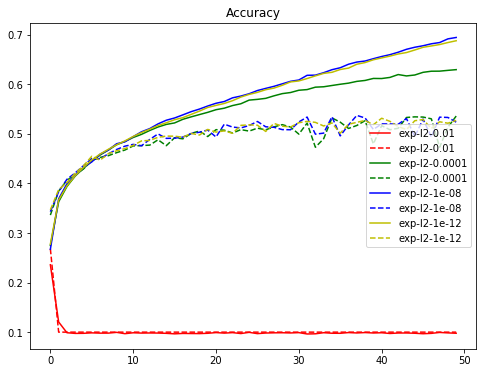

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()